In [30]:
%matplotlib inline

In [100]:
import numpy as np
import scipy.optimize
import copy
def tls_fidecay(x, y, yvar=None, shape='osc_double_exp'):
    """ Fit an decaying function, double exp with cosine.
    If other decay shape, pass on to expt_fitter.fidecay()
      return (fit_parameters, f(x, **fp) from fit)
      parameters are offset, amplitude, decay constant """
    if shape != 'osc_double_exp':
        (fit, ffunc) = fidecay(x, y, yvar=None, shape=shape)
    else:
        iguess = {'amp': 0.95,
                  'tau': np.mean(x),
                  'tau2': np.mean(x)/100., #0.01,
                  'tau3': np.mean(x)/5.}
        ffunc = lambda x, amp, tau, tau2, tau3: amp*np.exp(-(x/tau)) + (1-amp)*np.exp(-x/tau2)*np.cos((2*np.pi*x)/tau3)
        fit_bounds = ([0,0,0,2],[1,5000,200,x[-1]])
        fit = fitwrap_osc_double_exp(ffunc, x, y, iguess, fit_bounds, yvar=yvar)
        #calculate T1/e and T90
#        fit['fp']['tau'] = np.abs(fit['fp']['tau'])
#       fit['fp']['tau2'] = np.abs(fit['fp']['tau2'])
        def targetf(x, target):
            return (ffunc(x, **fit['fp']) - target)**2
        t1_e = 0.0
        for n in range(1,5):
            guess = [[n*fit['fp']['tau']], [1.001*n*fit['fp']['tau']]]
            result = scipy.optimize.fmin(lambda x: targetf(x, np.exp(-1)), 3*fit['fp']['tau'], disp=False, full_output=True, initial_simplex=guess)
            t1_e_try = result[0]
            minval = result[1]
            if (t1_e_try > t1_e) and (minval < 0.01):
                t1_e = t1_e_try
        t90 = scipy.optimize.fmin(lambda x: targetf(x, 0.9), 0., disp=False)[0]
        def parameter_error(t, pars, parvars):
            a = pars['amp']
            c = 0.0 # pars['offset']
            Tc = pars['tau']
            Ta = pars['tau2']
            Tb = pars['tau3']
            var_a = parvars['amp']
            var_c = 0.0 #parvars['offset']
            var_Tc = parvars['tau']
            var_Ta = parvars['tau2']
            var_Tb = parvars['tau3']
            dyda = np.exp(-(t/Tc)) - np.cos((2*np.pi*t)/Tb)/np.exp(t/Ta)
            dydc = 1 - np.cos((2*np.pi*t)/Tb)/np.exp(t/Ta)
            dydTa = -(((a + c-1)*t*np.cos((2*np.pi*t)/Tb))/(np.exp(t/Ta)*Ta**2))
            dydTb = (-2* (a + c-1)*np.pi*t*np.sin((2*np.pi*t)/Tb))/(np.exp(t/Ta)*Tb**2)
            dydTc = (a*t)/(np.exp(t/Tc)*Tc**2)
            dydt = -(a/(np.exp(t/Tc)*Tc)) - ((1 - a - c)*np.cos((2*np.pi*t)/Tb))/(np.exp(t/Ta)*Ta) - (2*(1 - a - c)*np.pi*np.sin((2*np.pi*t)/Tb))/(np.exp(t/Ta)*Tb)    
    
            dy = np.sqrt(dyda*dyda*var_a + dydc*dydc*var_c + dydTa*dydTa*var_Ta + 
                 dydTb*dydTb*var_Tb + dydTc*dydTc*var_Tc)
    
            err_t = np.abs(dy/dydt)
    
            return err_t
        t1_e_var = (parameter_error(t1_e, fit['fp'], fit['var']))**2
        t90_var = (parameter_error(t90, fit['fp'], fit['var']))**2
        nonexp = 9.4912*t90/t1_e
        fit['extra'] ={'t1_e': t1_e, 't90': t90, 't1_e_var': t1_e_var, 't90_var': t90_var, 'nonexp': nonexp}
    return (fit, ffunc)

def fitwrap_osc_double_exp(fn, x, y, p0,fit_bounds, yvar=None):
    """ Simplied version of fitwrap to handle the oscillating double exponential fit
    used for fitting non-exponential T1 decays (i.e., where there is strong TLS
    interaction. Uses scipy.optimize.curve_fit instead of scipy.optimize.leastsq
    to conveniently bound some of the parameters.
    
  
    returns (p, pcov, chisq)"""
# fit_bounds are to limit the range of parameters: amp, tau, tau2 and tau3 (in that order)
# Try 0<amp<1, 0<tau<5000 us, 0<tau2<200 us, 2<tau3<200 us

    if yvar is not None:
        sigma = np.sqrt(yvar)
        good_inds = np.isfinite(y) & np.isfinite(sigma)
        sigma = sigma[good_inds]
    else:
        sigma = None        
        good_inds = np.isfinite(y)

    x = x[good_inds]
    y = y[good_inds]
    # Note: exactly one extra point is ok and still get variances:
    if np.sum(good_inds) < len(p0) + 1:
        log.warning('Not enough data to fit parameters.  Returning bogus data')
        return {'fp': p0, 'cov': None,
                'var': {k: np.nan for k in p0},
                'chisq': np.nan}
    # p0 is a dict.. mask is a dict...  protect p0
    p0 = copy.deepcopy(p0)


    # fix namespace collision if htere's a fit param named x
    fit_func_x = x
    ffn = fn
    fy = y 
    mask = list(p0.keys())

    try:
        popt, pcov = scipy.optimize.curve_fit(
            ffn,fit_func_x,fy,[p0[k] for k in mask], bounds = fit_bounds)
    except:
        popt = [p0[k] for k in mask]
        pcov = np.diagflat([0,0,0,0])
        
    if sigma is None:
        chisq = np.sum((ffn(fit_func_x,*popt)-fy)**2)
    else:
        chisq = np.sum(((ffn(fit_func_x,*popt)-fy)/sigma)**2)


    # Calculate reduced chi^2
    dof = len(x)-len(popt)
    chisq /= dof



    # construct results dictionary
    opt_params = dict(zip(mask, popt))
    p0.update(opt_params)


    cov = {}
    for ind1, field1 in enumerate(mask):
        if field1 not in cov:
            cov[field1] = {}
        for ind2, field2 in enumerate(mask):
            cov[field1][field2] = pcov[ind1, ind2]
    var = {}
    for field in mask:
        var[field] = cov[field][field]
    retval = {'fp': p0, 'cov': cov, 'var': var, 'chisq': chisq}

    return retval


In [101]:
import matplotlib.pyplot as plt
%matplotlib inline


({'fp': {'amp': 0.9786518145779667,
   'tau': 203.56593497239197,
   'tau2': 115.17779394065968,
   'tau3': 999.9999999999974},
  'cov': {'amp': {'amp': 0.0005905335178883775,
    'tau': -0.056761728556041155,
    'tau2': -0.20167274191307752,
    'tau3': -19.988528787763588},
   'tau': {'amp': -0.056761728556041155,
    'tau': 5.622267181484662,
    'tau2': 21.262465741687368,
    'tau3': 1835.7236434397164},
   'tau2': {'amp': -0.20167274191307752,
    'tau': 21.262465741687365,
    'tau2': 257.59692817212647,
    'tau3': 4983.367289699076},
   'tau3': {'amp': -19.988528787763588,
    'tau': 1835.7236434397164,
    'tau2': 4983.3672896990765,
    'tau3': 737971.3650038517}},
  'var': {'amp': 0.0005905335178883775,
   'tau': 5.622267181484662,
   'tau2': 257.59692817212647,
   'tau3': 737971.3650038517},
  'chisq': 1.5322868606235076e-06,
  'extra': {'t1_e': array([199.8203665]),
   't90': 21.080312500000026,
   't1_e_var': array([27.66071265]),
   't90_var': 0.23839447445296238,
   '

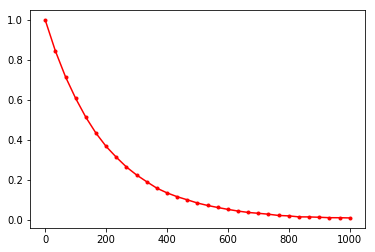

In [105]:
x=np.linspace(0,1000,31)
noise = 0.001
y=(1+np.random.normal()*noise)*(np.exp(-x/200.0) + noise*np.random.normal(size=x.shape))+np.random.normal()*noise
plt.plot(x,y,'.r-')
tls_fidecay(x,y)

/Users/odial/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in square
/Users/odial/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in double_scalars
/Users/odial/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars


mean 0.9341809102753128
median 0.9631123778252553


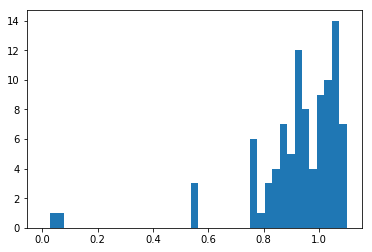

In [117]:
# Look at many fits for bias
ans=[]
for ii in range(100):
    p=1  # larger p puts more points near beginning.
    x=np.linspace(0,1000**(1/p),21)**(p)
    noise = 0.01
    scalenoise=noise
    y=(1+np.random.normal()*scalenoise)*(np.exp(-x/200.0) + noise*np.random.normal(size=x.shape))+np.random.normal()*scalenoise
    #plt.plot(x,y,'.r-')
    ans.append(tls_fidecay(x,y))
ne = [a[0]['extra']['nonexp'][0] for a in ans];
plt.hist(ne,range=(0,1.1),bins=41)
print('mean', np.mean(ne))
print('median', np.median(ne))

{'fp': {'amp': 0.976547505955013,
  'tau': 497.0568475922144,
  'tau2': 165.9726203096751,
  'tau3': 28.19776546200504},
 'cov': {'amp': {'amp': 1.3220197312942947e-05,
   'tau': -0.007981360869647361,
   'tau2': 0.09582659730857102,
   'tau3': 3.4535536259433377e-06},
  'tau': {'amp': -0.007981360869647361,
   'tau': 9.375768967630483,
   'tau2': -57.7008448798127,
   'tau3': -0.002184450750017506},
  'tau2': {'amp': 0.095826597308571,
   'tau': -57.7008448798127,
   'tau2': 4766.533763836674,
   'tau3': 0.03421365053759965},
  'tau3': {'amp': 3.4535536259433373e-06,
   'tau': -0.002184450750017506,
   'tau2': 0.03421365053759965,
   'tau3': 0.0858931275458552}},
 'var': {'amp': 1.3220197312942947e-05,
  'tau': 9.375768967630483,
  'tau2': 4766.533763836674,
  'tau3': 0.0858931275458552},
 'chisq': 8.427909754850871e-05,
 'extra': {'t1_e': array([485.57557466]),
  't90': 15.826625000000021,
  't1_e_var': array([8.40459475]),
  't90_var': 6519292226220.484,
  'nonexp': array([0.3093517